In [1]:
# CELL 0: Setup & imports
import os, random, math, time, json
from pathlib import Path
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, brier_score_loss
import joblib

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

INPUT_DIR = "/kaggle/input/afml-proj"
WORK_DIR = "/kaggle/working"
os.makedirs(WORK_DIR, exist_ok=True)

STATIC_CSV = os.path.join(INPUT_DIR, "static_embeddings.csv")
TEMP_CSV   = os.path.join(INPUT_DIR, "temporal_embeddings_predictions.csv")
CLIN_CSV   = os.path.join(INPUT_DIR, "clinical_embeddings.csv")
RAD_CSV    = os.path.join(INPUT_DIR, "radiology_embeddings.csv")
MERGED_PATH = os.path.join(WORK_DIR, "merged_fusion_table.csv")

LABEL_COL = "ventilation_within_12h"


Device: cuda


In [2]:
# ======================================================
# CELL 1: Load and merge modality CSVs (with ID normalization & clinical scaling)
# ======================================================

def safe_read(path):
    print(f"Reading: {path}")
    return pd.read_csv(path, low_memory=False)

# Delete old merged file
if os.path.exists(MERGED_PATH):
    os.remove(MERGED_PATH)
    print(f"Deleted old merged table: {MERGED_PATH}")

# If merged exists, load it directly
if os.path.exists(MERGED_PATH):
    merged = safe_read(MERGED_PATH)
    print("Loaded existing merged table:", MERGED_PATH, merged.shape)

else:
    # ------------------------------------------------------
    # Load all modality files
    # ------------------------------------------------------
    static_df      = safe_read(STATIC_CSV)
    temp_df        = safe_read(TEMP_CSV)
    clin_df        = safe_read(CLIN_CSV)
    rad_df         = safe_read(RAD_CSV)
    static_emb_df  = safe_read("/kaggle/input/afml-proj/static_embeddings.csv")

    # ------------------------------------------------------
    # Normalize IDs for ALL dataframes
    # ------------------------------------------------------
    def normalize_id(col):
        return (
            col.astype(str)
            .str.strip()
            .str.replace(".0", "", regex=False)
            .str.replace(" ", "", regex=False)
        )

    for d in (static_df, temp_df, clin_df, rad_df, static_emb_df):
        for id_col in ["stay_id", "subject_id"]:
            if id_col in d.columns:
                d[id_col] = normalize_id(d[id_col])

    # ------------------------------------------------------
    # Clinical embedding scaling
    # ------------------------------------------------------
    if "subject_id" in clin_df.columns:
        numeric_cols = [c for c in clin_df.columns if np.issubdtype(clin_df[c].dtype, np.number)]
        max_val = clin_df[numeric_cols].abs().max().max()
        clin_df[numeric_cols] = clin_df[numeric_cols] / max_val
        print(f"Scaled clinical embeddings using max={max_val:.2f}")

    # ------------------------------------------------------
    # MERGING STARTS HERE
    # ------------------------------------------------------

    print("Merging static DNN embeddings on stay_id ...")
    merged = static_df.merge(static_emb_df, how="left", on="stay_id")

    print("Merging temporal embeddings on stay_id ...")
    merged = merged.merge(temp_df, how="left", on="stay_id")

    print("Unique subject_id count in merged:", merged['subject_id'].nunique())
    print("First 10 subject_ids:", merged['subject_id'].head(10).tolist())

    # ---- Merge clinical embeddings ----
    if "subject_id" in clin_df.columns:
        print("Merging clinical embeddings on subject_id ...")
        clin_agg = clin_df.groupby("subject_id").mean(numeric_only=True).reset_index()
        merged = merged.merge(clin_agg, how="left", on="subject_id")

    # ---- Merge radiology embeddings ----
    if "subject_id" in rad_df.columns:
        print("Merging radiology embeddings on subject_id ...")
        rad_agg = rad_df.groupby("subject_id").mean(numeric_only=True).reset_index()
        merged = merged.merge(rad_agg, how="left", on="subject_id")

    merged.to_csv(MERGED_PATH, index=False)
    print(f"✅ Merged saved to: {MERGED_PATH}, shape: {merged.shape}")

# ------------------------------------------------------
# Detect embedding blocks using actual merged column names
# ------------------------------------------------------

all_cols = merged.columns

# STATIC (both original and embedding CSV)
static_cols = [c for c in all_cols if c.startswith("static_emb_") and c.endswith("_y")]

# TEMPORAL (Transformer outputs)
temporal_cols = [c for c in all_cols if c.startswith("emb_")]

# CLINICAL (numeric columns merged with no prefix but become *_x)
clin_cols = [c for c in all_cols 
             if c.endswith("_x") 
             and c.split("_")[0].isdigit()]   # numeric column name

# RADIOLOGY (numeric columns merged become *_y)
rad_cols = [c for c in all_cols 
            if c.endswith("_y") 
            and c.split("_")[0].isdigit()]    # numeric column name

print(f"Detected → static={len(static_cols)} | temporal={len(temporal_cols)} | clinical={len(clin_cols)} | radiology={len(rad_cols)}")

# ------------------------------------------------------
# Presence check
# ------------------------------------------------------
def check_presence(df, cols, name):
    if len(cols) == 0:
        print(f"{name}: NONE")
        return
    frac = (df[cols].abs().sum(axis=1) > 0).mean()
    print(f"{name} presence: {frac:.3f}")

check_presence(merged, static_cols, "Static")
check_presence(merged, temporal_cols, "Temporal")
check_presence(merged, clin_cols, "Clinical")
check_presence(merged, rad_cols, "Radiology")


Reading: /kaggle/input/afml-proj/static_embeddings.csv
Reading: /kaggle/input/afml-proj/temporal_embeddings_predictions.csv
Reading: /kaggle/input/afml-proj/clinical_embeddings.csv
Reading: /kaggle/input/afml-proj/radiology_embeddings.csv
Reading: /kaggle/input/afml-proj/static_embeddings.csv
Scaled clinical embeddings using max=9.64
Merging static DNN embeddings on stay_id ...
Merging temporal embeddings on stay_id ...
Unique subject_id count in merged: 6093
First 10 subject_ids: ['10002348', '10004113', '10010399', '10011507', '10011938', '10013310', '10017308', '10017308', '10018328', '10018328']
Merging clinical embeddings on subject_id ...
Merging radiology embeddings on subject_id ...
✅ Merged saved to: /kaggle/working/merged_fusion_table.csv, shape: (10578, 1732)
Detected → static=32 | temporal=128 | clinical=768 | radiology=768
Static presence: 1.000
Temporal presence: 0.960
Clinical presence: 0.473
Radiology presence: 0.576


In [3]:
# ======================================================
# CELL 2: Preprocessing & train/val/test splits
# ======================================================

df = merged.copy()

# Ensure IDs are string
for c in ['subject_id','stay_id']:
    if c in df.columns:
        df[c] = df[c].astype(str)


LABEL_COL = "true_label"


# ------------------------------------------------------
# STATIC COLUMNS (NUMERIC + CATEGORICAL)
# ------------------------------------------------------

exclude = set(
    temporal_cols 
    + clin_cols 
    + rad_cols 
    + ['subject_id','stay_id', LABEL_COL]
)

numeric_static = static_cols
cat_static = []

print("Numeric static sample:", numeric_static[:10])
print("Categorical static sample:", cat_static[:10])

# ------------------------------------------------------
# Fill embedding NaNs with zeros
# ------------------------------------------------------

if len(temporal_cols) > 0:
    df[temporal_cols] = df[temporal_cols].fillna(0.0)

if len(clin_cols) > 0:
    df[clin_cols] = df[clin_cols].fillna(0.0)

if len(rad_cols) > 0:
    df[rad_cols] = df[rad_cols].fillna(0.0)

# ------------------------------------------------------
# Presence flags (optional but useful)
# ------------------------------------------------------

df['has_temporal']  = (df[temporal_cols].abs().sum(axis=1) > 0).astype(int) if len(temporal_cols)>0 else 0
df['has_clinical']  = (df[clin_cols].abs().sum(axis=1) > 0).astype(int)   if len(clin_cols)>0 else 0
df['has_radiology'] = (df[rad_cols].abs().sum(axis=1) > 0).astype(int)   if len(rad_cols)>0 else 0

# ======================================================
# SUBJECT-LEVEL train/val/test split (FIXED)
# ======================================================

# 1. Subject → label mapping
sub_label = (
    df.groupby('subject_id')[LABEL_COL]
      .max()
      .reset_index()
      .rename(columns={LABEL_COL: 'subject_label'})
)

# 2. Remove subjects with missing label
sub_label = sub_label[sub_label['subject_label'].notna()].copy()

# 3. Convert label to int (required for stratify)
sub_label['subject_label'] = sub_label['subject_label'].astype(int)

print("Total subjects with label:", len(sub_label))

# 4. First split: train vs test
train_sub, test_sub = train_test_split(
    sub_label,
    test_size=0.20,
    random_state=SEED,
    stratify=sub_label['subject_label']
)

# 5. Second split: train → train vs val
train_sub, val_sub = train_test_split(
    train_sub,
    test_size=0.1111,      # gives 20% test, 10% val, 70% train
    random_state=SEED,
    stratify=train_sub['subject_label']
)

print("Subjects in train:", len(train_sub))
print("Subjects in val:", len(val_sub))
print("Subjects in test:", len(test_sub))

# 6. Extract stays
train_df = df[df['subject_id'].isin(train_sub['subject_id'])]
val_df   = df[df['subject_id'].isin(val_sub['subject_id'])]
test_df  = df[df['subject_id'].isin(test_sub['subject_id'])]

print("Sizes (stays):", len(train_df), len(val_df), len(test_df))


# ------------------------------------------------------
# STATIC FEATURES: STANDARDIZE NUMERICS
# ------------------------------------------------------

scaler = StandardScaler()

if len(numeric_static) > 0:
    scaler.fit(train_df[numeric_static].fillna(0.0))
    
    X_train_num = scaler.transform(train_df[numeric_static].fillna(0.0)).astype(np.float32)
    X_val_num   = scaler.transform(val_df[numeric_static].fillna(0.0)).astype(np.float32)
    X_test_num  = scaler.transform(test_df[numeric_static].fillna(0.0)).astype(np.float32)
else:
    X_train_num = np.zeros((len(train_df),0), dtype=np.float32)
    X_val_num   = np.zeros((len(val_df),0),  dtype=np.float32)
    X_test_num  = np.zeros((len(test_df),0), dtype=np.float32)

# ------------------------------------------------------
# CATEGORICAL STATIC → ONE-HOT
# ------------------------------------------------------

if len(cat_static) > 0:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(train_df[cat_static].fillna("NA"))
    
    X_train_cat = ohe.transform(train_df[cat_static].fillna("NA")).astype(np.float32)
    X_val_cat   = ohe.transform(val_df[cat_static].fillna("NA")).astype(np.float32)
    X_test_cat  = ohe.transform(test_df[cat_static].fillna("NA")).astype(np.float32)
else:
    X_train_cat = np.zeros((len(train_df),0), dtype=np.float32)
    X_val_cat   = np.zeros((len(val_df),0),  dtype=np.float32)
    X_test_cat  = np.zeros((len(test_df),0), dtype=np.float32)

# Combine static num + cat
X_train_static = np.hstack([X_train_num, X_train_cat]).astype(np.float32)
X_val_static   = np.hstack([X_val_num,  X_val_cat]).astype(np.float32)
X_test_static  = np.hstack([X_test_num, X_test_cat]).astype(np.float32)

# ------------------------------------------------------
# MODALITY EMBEDDING MATRICES
# ------------------------------------------------------

X_train_temp = train_df[temporal_cols].values.astype(np.float32)
X_val_temp   = val_df[temporal_cols].values.astype(np.float32)
X_test_temp  = test_df[temporal_cols].values.astype(np.float32)

X_train_clin = train_df[clin_cols].values.astype(np.float32)
X_val_clin   = val_df[clin_cols].values.astype(np.float32)
X_test_clin  = test_df[clin_cols].values.astype(np.float32)

X_train_rad = train_df[rad_cols].values.astype(np.float32)
X_val_rad   = val_df[rad_cols].values.astype(np.float32)
X_test_rad  = test_df[rad_cols].values.astype(np.float32)

# ------------------------------------------------------
# TARGET LABELS
# ------------------------------------------------------

y_train = train_df[LABEL_COL].astype(int).values
y_val   = val_df[LABEL_COL].astype(int).values
y_test  = test_df[LABEL_COL].astype(int).values

# presence masks
has_train_temp = train_df['has_temporal'].astype(int).values
has_train_clin = train_df['has_clinical'].astype(int).values
has_train_rad  = train_df['has_radiology'].astype(int).values

# ------------------------------------------------------
# SAVE PREPROCESSORS
# ------------------------------------------------------

joblib.dump({
    'scaler': scaler,
    'ohe': (ohe if len(cat_static)>0 else None),
    'numeric_static': numeric_static,
    'cat_static': cat_static,
    'temporal_cols': temporal_cols,
    'clin_cols': clin_cols,
    'rad_cols': rad_cols
}, os.path.join(WORK_DIR, "fusion_preprocessors.pkl"))

print("Saved preprocessors to", os.path.join(WORK_DIR, "fusion_preprocessors.pkl"))


Numeric static sample: ['static_emb_0_y', 'static_emb_1_y', 'static_emb_2_y', 'static_emb_3_y', 'static_emb_4_y', 'static_emb_5_y', 'static_emb_6_y', 'static_emb_7_y', 'static_emb_8_y', 'static_emb_9_y']
Categorical static sample: []


/tmp/ipykernel_39/3174573828.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['has_temporal']  = (df[temporal_cols].abs().sum(axis=1) > 0).astype(int) if len(temporal_cols)>0 else 0
/tmp/ipykernel_39/3174573828.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['has_clinical']  = (df[clin_cols].abs().sum(axis=1) > 0).astype(int)   if len(clin_cols)>0 else 0
/tmp/ipykernel_39/3174573828.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Total subjects with label: 6093
Subjects in train: 4332
Subjects in val: 542
Subjects in test: 1219
Sizes (stays): 7558 776 1817
Saved preprocessors to /kaggle/working/fusion_preprocessors.pkl


In [4]:
# CELL 3: Dataset and DataLoader with modality dropout
class FusionDataset(Dataset):
    def __init__(self, X_static, X_temp, X_clin, X_rad, y, has_temp=None, has_clin=None, has_rad=None, modal_dropout_p=0.0):
        self.X_static = X_static
        self.X_temp = X_temp
        self.X_clin = X_clin
        self.X_rad = X_rad
        self.y = y
        self.modal_dropout_p = modal_dropout_p
        self.has_temp = has_temp if has_temp is not None else (np.abs(X_temp).sum(axis=1)>0).astype(int)
        self.has_clin = has_clin if has_clin is not None else (np.abs(X_clin).sum(axis=1)>0).astype(int)
        self.has_rad  = has_rad  if has_rad  is not None else (np.abs(X_rad).sum(axis=1)>0).astype(int)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        s = self.X_static[idx] if self.X_static.shape[1]>0 else np.zeros((0,),dtype=np.float32)
        t = self.X_temp[idx] if self.X_temp.shape[1]>0 else np.zeros((0,),dtype=np.float32)
        c = self.X_clin[idx] if self.X_clin.shape[1]>0 else np.zeros((0,),dtype=np.float32)
        r = self.X_rad[idx] if self.X_rad.shape[1]>0 else np.zeros((0,),dtype=np.float32)
        has_t,has_c,has_r = int(self.has_temp[idx]), int(self.has_clin[idx]), int(self.has_rad[idx])
        # modality dropout: randomly zero-out present modalities
        if self.modal_dropout_p>0:
            if has_t and random.random() < self.modal_dropout_p: t = np.zeros_like(t)
            if has_c and random.random() < self.modal_dropout_p: c = np.zeros_like(c)
            if has_r and random.random() < self.modal_dropout_p: r = np.zeros_like(r)
        return {
            'static': torch.from_numpy(s).float(),
            'temp': torch.from_numpy(t).float(),
            'clin': torch.from_numpy(c).float(),
            'rad': torch.from_numpy(r).float(),
            'has_temp': torch.tensor(has_t, dtype=torch.float32),
            'has_clin': torch.tensor(has_c, dtype=torch.float32),
            'has_rad': torch.tensor(has_r, dtype=torch.float32),
            'label': torch.tensor(self.y[idx], dtype=torch.float32)
        }

BATCH_SIZE = 64
train_ds = FusionDataset(X_train_static, X_train_temp, X_train_clin, X_train_rad, y_train,
                         has_temp=has_train_temp, has_clin=has_train_clin, has_rad=has_train_rad, modal_dropout_p=0.15)
val_ds = FusionDataset(X_val_static, X_val_temp, X_val_clin, X_val_rad, y_val, modal_dropout_p=0.0)
test_ds = FusionDataset(X_test_static, X_test_temp, X_test_clin, X_test_rad, y_test, modal_dropout_p=0.0)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Loaders:", len(train_loader), len(val_loader), len(test_loader))


Loaders: 119 13 29


In [5]:
# ======================================================
# CELL 4: Balanced Gated Fusion Model (Shallow + Normalized)
# ======================================================

class GatedFusionModel(nn.Module):
    def __init__(self, static_dim, temp_dim, clin_dim, rad_dim,
                 proj_dim=128, hidden=128, dropout=0.2):
        super().__init__()
        self.proj_dim = proj_dim

        # -----------------------------
        # 1) Modality projection layers
        # -----------------------------
        def make_proj(in_dim, proj_dim):
            if in_dim == 0:
                return None
            return nn.Sequential(
                nn.Linear(in_dim, proj_dim),
                nn.ReLU()
            )

        self.static_proj = make_proj(static_dim, proj_dim)
        self.temp_proj   = make_proj(temp_dim, proj_dim)
        self.clin_proj   = make_proj(clin_dim, proj_dim)
        self.rad_proj    = make_proj(rad_dim, proj_dim)

        # -----------------------------
        # 2) Gating layers
        # -----------------------------
        def make_gate(proj_dim):
            return nn.Sequential(
                nn.Linear(proj_dim, proj_dim // 2),
                nn.ReLU(),
                nn.Linear(proj_dim // 2, 1)
            )

        self.gate_static = make_gate(proj_dim) if static_dim > 0 else None
        self.gate_temp   = make_gate(proj_dim) if temp_dim > 0 else None
        self.gate_clin   = make_gate(proj_dim) if clin_dim > 0 else None
        self.gate_rad    = make_gate(proj_dim) if rad_dim > 0 else None

        # -----------------------------
        # 3) Classifier
        # -----------------------------
        self.classifier = nn.Sequential(
            nn.Linear(proj_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )

    # -----------------------------
    # Forward pass
    # -----------------------------
    def forward(self, static_x, temp_x, clin_x, rad_x):

        mods = []
        gates = []

        # ---- STATIC ----
        if self.static_proj is not None:
            s = self.static_proj(static_x)
            s = s / (s.norm(dim=1, keepdim=True) + 1e-8)     # 🔥 Normalize
            mods.append(s)
            gates.append(self.gate_static(s))

        # ---- TEMPORAL ----
        if self.temp_proj is not None:
            t = self.temp_proj(temp_x)
            t = t / (t.norm(dim=1, keepdim=True) + 1e-8)     # 🔥 Normalize
            mods.append(t)
            gates.append(self.gate_temp(t))

        # ---- CLINICAL ----
        if self.clin_proj is not None:
            c = self.clin_proj(clin_x)
            c = c / (c.norm(dim=1, keepdim=True) + 1e-8)     # 🔥 Normalize
            mods.append(c)
            gates.append(self.gate_clin(c))

        # ---- RADIOLOGY ----
        if self.rad_proj is not None:
            r = self.rad_proj(rad_x)
            r = r / (r.norm(dim=1, keepdim=True) + 1e-8)     # 🔥 Normalize
            mods.append(r)
            gates.append(self.gate_rad(r))

        # ---- Gating ----
        gate_tensor = torch.cat(gates, dim=1)          # (B, M)
        gate_weights = torch.softmax(gate_tensor, 1)   # (B, M)

        # ---- Weighted Fusion ----
        fused = torch.zeros_like(mods[0])
        for i, m in enumerate(mods):
            fused += m * gate_weights[:, i:i+1]

        logits = self.classifier(fused).squeeze(1)
        return logits, gate_weights


In [6]:
# ======================================================
# CELL 5: Training loop (with balanced gate regularization)
# ======================================================

static_dim = X_train_static.shape[1]
temp_dim   = X_train_temp.shape[1]
clin_dim   = X_train_clin.shape[1]
rad_dim    = X_train_rad.shape[1]
print("Dims static,temp,clin,rad:", static_dim, temp_dim, clin_dim, rad_dim)

model = GatedFusionModel(static_dim, temp_dim, clin_dim, rad_dim,
                         proj_dim=128, hidden=128, dropout=0.2).to(DEVICE)
print(model)

# ------------------------------------------------------
# Loss + optimizer setup
# ------------------------------------------------------
pos = y_train.sum(); neg = (len(y_train)-pos)
pos_weight = torch.tensor([(neg / (pos + 1e-9))]).to(DEVICE)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# ------------------------------------------------------
# Gate regularizer hyperparameters
# ------------------------------------------------------
LAMBDA_GATE_UNIFORM = 0.1    # push gates to share weight among present modalities
LAMBDA_GATE_BIAS    = 0.001  # small bias toward equal weighting (≈0.25 each)
MAX_EPOCHS = 40
best_val_ap = -1.0
best_ckpt = os.path.join(WORK_DIR, "best_fusion_retrain_ckpt.pth")
patience = 12
no_improve = 0


def compute_gate_reg(gates, has_mask):
    """
    Encourage gates to distribute weights evenly among *present* modalities.
    """
    s = has_mask.sum(dim=1, keepdim=True).clamp(min=1.0)
    uniform = has_mask / s  # desired uniform weights among present modalities
    reg = ((gates - uniform) * has_mask).pow(2).sum(dim=1) / (s.squeeze() + 1e-9)
    return reg.mean()


# ------------------------------------------------------
# Training loop
# ------------------------------------------------------
for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    epoch_losses = []

    for batch in train_loader:
        optimizer.zero_grad()

        s = batch["static"].to(DEVICE)
        t = batch["temp"].to(DEVICE)
        c = batch["clin"].to(DEVICE)
        r = batch["rad"].to(DEVICE)
        label = batch["label"].to(DEVICE)

        has_temp = batch["has_temp"].to(DEVICE)
        has_clin = batch["has_clin"].to(DEVICE)
        has_rad  = batch["has_rad"].to(DEVICE)

        # Stack presence mask (static always assumed present)
        has_mask = []
        if model.static_proj is not None:
            has_mask.append(torch.ones_like(has_temp))
        if model.temp_proj is not None:
            has_mask.append(has_temp)
        if model.clin_proj is not None:
            has_mask.append(has_clin)
        if model.rad_proj is not None:
            has_mask.append(has_rad)
        has_mask = torch.stack(has_mask, dim=1).float()  # (B, M)

        # Forward
        logits, gates = model(s, t, c, r)
        loss_main = bce_loss(logits, label)

        # --- Gate regularization ---
        reg_uniform = compute_gate_reg(gates, has_mask)  # encourage balanced use of present modalities
        loss = loss_main + LAMBDA_GATE_UNIFORM * reg_uniform

        # Backprop
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    # ------------------------------------------------------
    # Validation
    # ------------------------------------------------------
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            s = batch["static"].to(DEVICE)
            t = batch["temp"].to(DEVICE)
            c = batch["clin"].to(DEVICE)
            r = batch["rad"].to(DEVICE)
            label = batch["label"].cpu().numpy()

            logits, _ = model(s, t, c, r)
            probs = torch.sigmoid(logits).cpu().numpy()
            val_probs.append(probs)
            val_labels.append(label)

    val_probs = np.concatenate(val_probs)
    val_labels = np.concatenate(val_labels)
    val_auprc = average_precision_score(val_labels, val_probs)
    val_auroc = roc_auc_score(val_labels, val_probs)
    avg_loss = np.mean(epoch_losses)

    print(f"Epoch {epoch}/{MAX_EPOCHS} "
          f"loss={avg_loss:.4f} val_auprc={val_auprc:.4f} val_auroc={val_auroc:.4f}")

    scheduler.step(val_auprc)

    # Save best checkpoint
    if val_auprc > best_val_ap:
        best_val_ap = val_auprc
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_probs": val_probs,
            "val_labels": val_labels,
            "scaler_ohe": os.path.join(WORK_DIR, "fusion_preprocessors.pkl")
        }, best_ckpt)
        print("✅ Saved best ckpt:", best_ckpt)
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"⏹️ Early stopping: no improvement for {patience} epochs")
        break

print("Training complete. Best val AUPRC:", best_val_ap)


Dims static,temp,clin,rad: 32 128 768 768
GatedFusionModel(
  (static_proj): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
  )
  (temp_proj): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
  )
  (clin_proj): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
  )
  (rad_proj): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
  )
  (gate_static): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (gate_temp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (gate_clin): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
 

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40 loss=1.1303 val_auprc=0.7750 val_auroc=0.9141
✅ Saved best ckpt: /kaggle/working/best_fusion_retrain_ckpt.pth
Epoch 2/40 loss=1.0936 val_auprc=0.7490 val_auroc=0.8930
Epoch 3/40 loss=1.0385 val_auprc=0.7709 val_auroc=0.9062
Epoch 4/40 loss=0.9740 val_auprc=0.7669 val_auroc=0.9041
Epoch 5/40 loss=0.9032 val_auprc=0.7789 val_auroc=0.9096
✅ Saved best ckpt: /kaggle/working/best_fusion_retrain_ckpt.pth
Epoch 6/40 loss=0.8373 val_auprc=0.7738 val_auroc=0.9115
Epoch 7/40 loss=0.7846 val_auprc=0.7766 val_auroc=0.9133
Epoch 8/40 loss=0.7379 val_auprc=0.7775 val_auroc=0.9151
Epoch 9/40 loss=0.7336 val_auprc=0.7793 val_auroc=0.9179
✅ Saved best ckpt: /kaggle/working/best_fusion_retrain_ckpt.pth
Epoch 10/40 loss=0.7084 val_auprc=0.7865 val_auroc=0.9192
✅ Saved best ckpt: /kaggle/working/best_fusion_retrain_ckpt.pth
Epoch 11/40 loss=0.7047 val_auprc=0.7906 val_auroc=0.9193
✅ Saved best ckpt: /kaggle/working/best_fusion_retrain_ckpt.pth
Epoch 12/40 loss=0.6790 val_auprc=0.7928 val_auroc=

In [7]:
# CELL 6: load best ckpt and evaluate on test set, isotonic calibration
ck = torch.load(best_ckpt, map_location=DEVICE, weights_only=False)
model.load_state_dict(ck['model_state_dict'])
model.eval()
# compute test probs
test_probs = []
test_labels = []
gates_list = []
with torch.no_grad():
    for batch in test_loader:
        s = batch['static'].to(DEVICE); t = batch['temp'].to(DEVICE); c = batch['clin'].to(DEVICE); r = batch['rad'].to(DEVICE)
        labels = batch['label'].cpu().numpy()
        logits, gates = model(s,t,c,r)
        probs = torch.sigmoid(logits).cpu().numpy()
        test_probs.append(probs); test_labels.append(labels); gates_list.append(gates.cpu().numpy())
test_probs = np.concatenate(test_probs)
test_labels = np.concatenate(test_labels)
gates_arr = np.vstack(gates_list)
print("Test AUROC:", roc_auc_score(test_labels, test_probs))
print("Test AUPRC:", average_precision_score(test_labels, test_probs))
print("Test F1 (0.5):", f1_score(test_labels, (test_probs>=0.5).astype(int)))
print("Test Brier:", brier_score_loss(test_labels, test_probs))

# isotonic calibration on val set (saved in ckpt)
val_probs = ck.get('val_probs')
val_labels = ck.get('val_labels')
if val_probs is not None and val_labels is not None:
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(val_probs, val_labels)
    test_probs_cal = iso.transform(test_probs)
    print("Calibrated test AUPRC:", average_precision_score(test_labels, test_probs_cal))
    # save calibrated test probs & labels
    np.save(os.path.join(WORK_DIR, "test_probs_calibrated.npy"), test_probs_cal)
else:
    test_probs_cal = test_probs
    print("No val probs saved in ckpt; skipping isotonic.")

# save inference outputs (with gates) aligned to test_df
out_df = test_df.reset_index(drop=True)[['subject_id','stay_id']].copy()
out_df['raw_prob'] = test_probs
out_df['calibrated_prob'] = test_probs_cal
out_df['pred_label'] = (out_df['calibrated_prob'] >= 0.5).astype(int)
# gates order: match model gating order: static,temp,clin,rad where present
modal_names = []
if model.static_proj is not None: modal_names.append('static')
if model.temp_proj is not None: modal_names.append('temp')
if model.clin_proj is not None: modal_names.append('clin')
if model.rad_proj is not None: modal_names.append('rad')
for i,name in enumerate(modal_names):
    out_df[f'gate_{name}'] = gates_arr[:, i]
out_df.to_csv(os.path.join(WORK_DIR, "fusion_test_outputs_retrained.csv"), index=False)
print("Saved test outputs to", os.path.join(WORK_DIR, "fusion_test_outputs_retrained.csv"))
# save checkpoint (redundant)
torch.save({'model_state_dict': model.state_dict(), 'preproc': os.path.join(WORK_DIR,"fusion_preprocessors.pkl")}, os.path.join(WORK_DIR, "final_fusion_retrained_ckpt.pth"))
print("Saved final ckpt")


Test AUROC: 0.9529906621875534
Test AUPRC: 0.8659373820154141
Test F1 (0.5): 0.7666666666666666
Test Brier: 0.06490361271039274
Calibrated test AUPRC: 0.8315305206439809
Saved test outputs to /kaggle/working/fusion_test_outputs_retrained.csv
Saved final ckpt


In [8]:
# CELL 7: ablation - zero clin, zero rad, zero both
def infer_batch_arrays(Xs, Xt, Xc, Xr):
    ds = FusionDataset(Xs, Xt, Xc, Xr, np.zeros((Xs.shape[0],)), modal_dropout_p=0.0)
    loader = DataLoader(ds, batch_size=128, shuffle=False)
    probs = []
    with torch.no_grad():
        for b in loader:
            s = b['static'].to(DEVICE); t = b['temp'].to(DEVICE); c = b['clin'].to(DEVICE); r = b['rad'].to(DEVICE)
            logits, _ = model(s,t,c,r)
            probs.append(torch.sigmoid(logits).cpu().numpy())
    return np.concatenate(probs)

base_probs = infer_batch_arrays(X_test_static, X_test_temp, X_test_clin, X_test_rad)
zero_clin_probs = infer_batch_arrays(X_test_static, X_test_temp, np.zeros_like(X_test_clin), X_test_rad)
zero_rad_probs = infer_batch_arrays(X_test_static, X_test_temp, X_test_clin, np.zeros_like(X_test_rad))
zero_both_probs = infer_batch_arrays(X_test_static, X_test_temp, np.zeros_like(X_test_clin), np.zeros_like(X_test_rad))

print("Base AUROC/AUPRC:", roc_auc_score(y_test, base_probs), average_precision_score(y_test, base_probs))
print("No-clin AUROC/AUPRC:", roc_auc_score(y_test, zero_clin_probs), average_precision_score(y_test, zero_clin_probs))
print("No-rad AUROC/AUPRC:", roc_auc_score(y_test, zero_rad_probs), average_precision_score(y_test, zero_rad_probs))
print("No-clin+rad AUROC/AUPRC:", roc_auc_score(y_test, zero_both_probs), average_precision_score(y_test, zero_both_probs))


Base AUROC/AUPRC: 0.9529906621875534 0.8659373820154141
No-clin AUROC/AUPRC: 0.952777145134658 0.8648431560780804
No-rad AUROC/AUPRC: 0.9525019453775931 0.86539839548483
No-clin+rad AUROC/AUPRC: 0.9522741938545047 0.8636307210322204


In [9]:
# CELL 8: Save artifacts for download
joblib.dump({'scaler':scaler, 'ohe': (ohe if len(cat_static)>0 else None),
             'numeric_static': numeric_static, 'cat_static': cat_static,
             'temporal_cols': temporal_cols, 'clin_cols': clin_cols, 'rad_cols': rad_cols},
            os.path.join(WORK_DIR,"fusion_preprocessors_final.pkl"))
print("Saved fusion_preprocessors_final.pkl")

# list generated files
print("Files in working dir:")
for f in os.listdir(WORK_DIR):
    if f.endswith(".pth") or f.endswith(".pkl") or f.endswith(".csv") or f.endswith(".npy"):
        print("-", f)


Saved fusion_preprocessors_final.pkl
Files in working dir:
- fusion_test_outputs_retrained.csv
- fusion_preprocessors.pkl
- test_probs_calibrated.npy
- fusion_preprocessors_final.pkl
- best_fusion_retrain_ckpt.pth
- merged_fusion_table.csv
- final_fusion_retrained_ckpt.pth


In [10]:
df = pd.read_csv("/kaggle/working/fusion_test_outputs_retrained.csv")
print(df[['gate_static','gate_temp','gate_clin','gate_rad']].mean())


gate_static    0.279763
gate_temp      0.507667
gate_clin      0.128808
gate_rad       0.083762
dtype: float64


In [11]:
# Recreate presence flags on merged table
merged['has_clinical'] = (merged[clin_cols].abs().sum(axis=1) > 0).astype(int)
merged['has_radiology'] = (merged[rad_cols].abs().sum(axis=1) > 0).astype(int)
merged['has_temporal'] = (merged[temporal_cols].abs().sum(axis=1) > 0).astype(int)

print("Clinical embeddings present:", (merged['has_clinical'] == 1).mean())
print("Radiology embeddings present:", (merged['has_radiology'] == 1).mean())
print("Clinical mean/std:",
      merged[clin_cols].mean().mean(), merged[clin_cols].std().mean())
print("Radiology mean/std:",
      merged[rad_cols].mean().mean(), merged[rad_cols].std().mean())


Clinical embeddings present: 0.4727736812251844
Radiology embeddings present: 0.5761958782378521
Clinical mean/std: -0.0008139535756618352 0.006661953178448488
Radiology mean/std: -0.007582291853095332 0.047050609324377636


In [12]:
!pip install captum --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's depend

In [13]:
# ======================================================
# Captum Integrated Gradients for Multimodal Fusion Model
# ======================================================

from captum.attr import IntegratedGradients
import torch
import numpy as np
import joblib
import os

# Ensure output dir
EXPLAIN_DIR = os.path.join(WORK_DIR, "explain")
os.makedirs(EXPLAIN_DIR, exist_ok=True)

model.eval()

# ---------- Build samples ----------
sample_size = min(30, len(X_test_static))
X_s = torch.tensor(X_test_static[:sample_size], dtype=torch.float32, device=DEVICE)
X_t = torch.tensor(X_test_temp[:sample_size], dtype=torch.float32, device=DEVICE)
X_c = torch.tensor(X_test_clin[:sample_size], dtype=torch.float32, device=DEVICE)
X_r = torch.tensor(X_test_rad[:sample_size], dtype=torch.float32, device=DEVICE)

# ---------- Wrapper for Captum ----------
def forward_func(s, t, c, r):
    logits, _ = model(s, t, c, r)
    return torch.sigmoid(logits)

ig = IntegratedGradients(forward_func)

# Baseline: zeros
baseline_s = torch.zeros_like(X_s)
baseline_t = torch.zeros_like(X_t)
baseline_c = torch.zeros_like(X_c)
baseline_r = torch.zeros_like(X_r)

# ---------- Compute attributions ----------
attr_s, attr_t, attr_c, attr_r = ig.attribute(
    inputs=(X_s, X_t, X_c, X_r),
    baselines=(baseline_s, baseline_t, baseline_c, baseline_r),
    n_steps=50,
    return_convergence_delta=False
)

# Convert to numpy
attr_s_np = attr_s.detach().cpu().numpy()
attr_t_np = attr_t.detach().cpu().numpy()
attr_c_np = attr_c.detach().cpu().numpy()
attr_r_np = attr_r.detach().cpu().numpy()

# ---------- Save ----------
outpath = os.path.join(EXPLAIN_DIR, "captum_integrated_gradients.pkl")
joblib.dump({
    "static": attr_s_np,
    "temp": attr_t_np,
    "clin": attr_c_np,
    "rad": attr_r_np
}, outpath)

print("Saved Captum IG attributions to:", outpath)


Saved Captum IG attributions to: /kaggle/working/explain/captum_integrated_gradients.pkl


In [14]:
# ============================================================
# CELL: Clean Feature Importance (Permutation + Occlusion)
# ============================================================

import numpy as np, joblib, time, os
from sklearn.metrics import average_precision_score, roc_auc_score
import torch

# ----------- Setup -----------

if "EXPLAIN_DIR" not in globals():
    EXPLAIN_DIR = "/kaggle/working/explain"
os.makedirs(EXPLAIN_DIR, exist_ok=True)

WINDOW = "fusion"   # Name used for saved files


# ----------- Helper: Model Prediction Wrapper -----------

def eval_probs_arrays(S, T, C, R, batch_size=256):
    """Return model probabilities for given modalities."""
    B = S.shape[0]
    probs = []
    with torch.no_grad():
        for i in range(0, B, batch_size):
            s = torch.tensor(S[i:i+batch_size], dtype=torch.float32).to(DEVICE)
            t = torch.tensor(T[i:i+batch_size], dtype=torch.float32).to(DEVICE)
            c = torch.tensor(C[i:i+batch_size], dtype=torch.float32).to(DEVICE)
            r = torch.tensor(R[i:i+batch_size], dtype=torch.float32).to(DEVICE)
            logits, _ = model(s, t, c, r)
            p = torch.sigmoid(logits).cpu().numpy()
            probs.append(p)
    return np.concatenate(probs)


# ============================================================
# 1) BASELINE PERFORMANCE (for comparison)
# ============================================================

base_probs = eval_probs_arrays(X_test_static, X_test_temp, X_test_clin, X_test_rad)
base_ap = average_precision_score(y_test, base_probs)
base_auroc = roc_auc_score(y_test, base_probs)

print(f"\n🔹 Baseline Performance")
print(f"  AUPRC = {base_ap:.4f}")
print(f"  AUROC = {base_auroc:.4f}\n")


# ============================================================
# 2) PERMUTATION IMPORTANCE — STATIC FEATURES ONLY
# ============================================================

if X_test_static.shape[1] > 0:
    n_static = X_test_static.shape[1]
    n_eval = min(20, n_static)

    print(f"🔹 Running Permutation Importance on top {n_eval} static features...\n")

    perm_import = []
    rng = np.random.RandomState(42)

    for col in range(n_eval):
        S_perm = X_test_static.copy()
        S_perm[:, col] = rng.permutation(S_perm[:, col])

        probs_perm = eval_probs_arrays(S_perm, X_test_temp, X_test_clin, X_test_rad)
        ap_perm = average_precision_score(y_test, probs_perm)

        perm_import.append((
            col,
            ap_perm,
            base_ap - ap_perm
        ))

    perm_import_sorted = sorted(perm_import, key=lambda x: -x[2])

    print("Top static feature importance (by AUPRC drop):")
    for col, ap_after, delta in perm_import_sorted[:10]:
        name = numeric_static[col] if len(numeric_static) > col else f"static_{col}"
        print(f"  {name:20s} | ΔAUPRC = {delta:.5f}")

    joblib.dump(
        perm_import_sorted,
        os.path.join(EXPLAIN_DIR, f"perm_import_static_{WINDOW}.pkl")
    )
else:
    print("⚠️ No static features available for permutation.")


# ============================================================
# 3) OCCLUSION IMPORTANCE — EACH MODALITY
# ============================================================

print("\n🔹 Running Occlusion Importance (modality-level) ...\n")

def occlude_modalities():
    results = {}

    # Clinical
    probs = eval_probs_arrays(X_test_static, X_test_temp, np.zeros_like(X_test_clin), X_test_rad)
    results["no_clin"] = (roc_auc_score(y_test, probs), average_precision_score(y_test, probs))

    # Radiology
    probs = eval_probs_arrays(X_test_static, X_test_temp, X_test_clin, np.zeros_like(X_test_rad))
    results["no_rad"] = (roc_auc_score(y_test, probs), average_precision_score(y_test, probs))

    # Temporal
    probs = eval_probs_arrays(X_test_static, np.zeros_like(X_test_temp), X_test_clin, X_test_rad)
    results["no_temp"] = (roc_auc_score(y_test, probs), average_precision_score(y_test, probs))

    # Static
    probs = eval_probs_arrays(np.zeros_like(X_test_static), X_test_temp, X_test_clin, X_test_rad)
    results["no_static"] = (roc_auc_score(y_test, probs), average_precision_score(y_test, probs))

    return results


occl_results = occlude_modalities()

print("Occlusion Results (AUROC, AUPRC):")
for mod, (auc, ap) in occl_results.items():
    print(f"  {mod:10s} | AUROC={auc:.4f}  AUPRC={ap:.4f}")

joblib.dump(
    occl_results,
    os.path.join(EXPLAIN_DIR, f"occlusion_{WINDOW}.pkl")
)

print("\n✅ Importance analysis complete! Files saved in:", EXPLAIN_DIR)



🔹 Baseline Performance
  AUPRC = 0.8659
  AUROC = 0.9530

🔹 Running Permutation Importance on top 20 static features...

Top static feature importance (by AUPRC drop):
  static_emb_13_y      | ΔAUPRC = 0.00558
  static_emb_16_y      | ΔAUPRC = 0.00421
  static_emb_0_y       | ΔAUPRC = 0.00314
  static_emb_15_y      | ΔAUPRC = 0.00249
  static_emb_12_y      | ΔAUPRC = 0.00247
  static_emb_10_y      | ΔAUPRC = 0.00208
  static_emb_3_y       | ΔAUPRC = 0.00207
  static_emb_4_y       | ΔAUPRC = 0.00188
  static_emb_2_y       | ΔAUPRC = 0.00154
  static_emb_17_y      | ΔAUPRC = 0.00074

🔹 Running Occlusion Importance (modality-level) ...

Occlusion Results (AUROC, AUPRC):
  no_clin    | AUROC=0.9528  AUPRC=0.8648
  no_rad     | AUROC=0.9525  AUPRC=0.8654
  no_temp    | AUROC=0.8770  AUPRC=0.6300
  no_static  | AUROC=0.9312  AUPRC=0.8344

✅ Importance analysis complete! Files saved in: /kaggle/working/explain


In [15]:
# ===== Counterfactual analysis cell =====
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# helper inference using existing model & arrays (uses same device)
def infer_probs_from_arrays(S, T, C, R, batch=128):
    ds = FusionDataset(S, T, C, R, np.zeros((S.shape[0],)), modal_dropout_p=0.0)
    loader = DataLoader(ds, batch_size=batch, shuffle=False)
    probs = []
    with torch.no_grad():
        for b in loader:
            s = b['static'].to(DEVICE); t = b['temp'].to(DEVICE); c = b['clin'].to(DEVICE); r = b['rad'].to(DEVICE)
            logits, _ = model(s,t,c,r)
            probs.append(torch.sigmoid(logits).cpu().numpy())
    return np.concatenate(probs)

# utility to find column by substring
def find_idx(names, patterns):
    for patt in patterns:
        for i,name in enumerate(names):
            if patt.lower() in name.lower():
                return i, name
    return None, None

# build static names list used earlier
static_names = numeric_static + ( [f"cat_{i}" for i in range(X_train_cat.shape[1])] if ('X_train_cat' in globals() and X_train_cat.shape[1]>0) else [] )
temp_names = temporal_cols

# find likely columns
idx_sp_static, name_sp_static = find_idx(static_names, ["spo2","spO2","o2","oxygen","sat"])
idx_hr_static, name_hr_static = find_idx(static_names, ["heart","hr","heartrate","pulse"])
idx_gcs_static, name_gcs_static = find_idx(static_names, ["gcs","gcs_motor","gcs_eye","gcs_verbal","gcs_"])
idx_neuro_flag, name_neuro_flag = find_idx(static_names, ["neuro_consult","neuroconsult","neuro_consult_flag","consult_neuro","neuro_flag"])

print("Found static columns:", 
      ("SpO2:"+str(name_sp_static)), ("HR:"+str(name_hr_static)), ("GCS:"+str(name_gcs_static)), ("neuro_flag:"+str(name_neuro_flag)))

# precompute baseline probs
base_probs = infer_probs_from_arrays(X_test_static, X_test_temp, X_test_clin, X_test_rad)
print("Baseline mean prob:", base_probs.mean())

# COUNTERFACTUAL 1: Increase SpO2 by +5% absolute or +0.05 if normalized
if idx_sp_static is not None:
    S_sp = X_test_static.copy()
    med = np.median(S_sp[:, idx_sp_static])
    if med <= 1.01:
        S_sp[:, idx_sp_static] = np.clip(S_sp[:, idx_sp_static] + 0.05, 0.0, 1.0)
    else:
        S_sp[:, idx_sp_static] = S_sp[:, idx_sp_static] + 5.0
    probs_sp = infer_probs_from_arrays(S_sp, X_test_temp, X_test_clin, X_test_rad)
    delta_sp = probs_sp - base_probs
    print(f"SpO2 +5 effect: mean Δprob = {delta_sp.mean():.6f}, median Δ = {np.median(delta_sp):.6f}")
else:
    print("SpO2 column not found — skipping SpO2 counterfactual.")

# COUNTERFACTUAL 2: Decrease HR by 10% relative (if HR present)
if idx_hr_static is not None:
    S_hr = X_test_static.copy()
    S_hr[:, idx_hr_static] = S_hr[:, idx_hr_static] * 0.9
    probs_hr = infer_probs_from_arrays(S_hr, X_test_temp, X_test_clin, X_test_rad)
    delta_hr = probs_hr - base_probs
    print(f"HR -10% effect: mean Δprob = {delta_hr.mean():.6f}")
else:
    print("HR column not found — skipping HR counterfactual.")

# COUNTERFACTUAL 3: Increase GCS by +1 (if numeric)
if idx_gcs_static is not None:
    S_gcs = X_test_static.copy()
    S_gcs[:, idx_gcs_static] = S_gcs[:, idx_gcs_static] + 1.0
    probs_gcs = infer_probs_from_arrays(S_gcs, X_test_temp, X_test_clin, X_test_rad)
    delta_gcs = probs_gcs - base_probs
    print(f"GCS +1 effect: mean Δprob = {delta_gcs.mean():.6f}")
else:
    print("GCS column not found — skipping GCS counterfactual.")

# COUNTERFACTUAL 4: Toggle neuro_consult flag to 1
if idx_neuro_flag is not None:
    S_neuro = X_test_static.copy()
    S_neuro[:, idx_neuro_flag] = 1.0
    probs_neuro = infer_probs_from_arrays(S_neuro, X_test_temp, X_test_clin, X_test_rad)
    delta_neuro = probs_neuro - base_probs
    print(f"Neuro consult toggle effect: mean Δprob = {delta_neuro.mean():.6f}")
else:
    print("Neuro consult flag not found — skipping.")

# Visualize distribution of deltas for the most meaningful perturbation (temporal or spO2)
# Identify top delta array
deltas = {}
if idx_sp_static is not None: deltas['spO2'] = delta_sp
if idx_hr_static is not None: deltas['hr'] = delta_hr
if idx_gcs_static is not None: deltas['gcs'] = delta_gcs
if idx_neuro_flag is not None: deltas['neuro'] = delta_neuro

for k,v in deltas.items():
    plt.figure(figsize=(5,3))
    plt.hist(v, bins=50)
    plt.title(f"Δprob distribution: {k}")
    plt.xlabel("Δprob"); plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# Save counterfactual summary CSV
cf_df = pd.DataFrame({'subject_id': test_df.reset_index(drop=True)['subject_id'],
                      'stay_id': test_df.reset_index(drop=True)['stay_id'],
                      'base_prob': base_probs})
if idx_sp_static is not None: cf_df['prob_spO2_plus5'] = probs_sp
if idx_hr_static is not None: cf_df['prob_hr_minus10p'] = probs_hr
if idx_gcs_static is not None: cf_df['prob_gcs_plus1'] = probs_gcs
if idx_neuro_flag is not None: cf_df['prob_neuro_flag_set'] = probs_neuro

cf_csv = os.path.join(WORK_DIR, f"counterfactuals_summary_{WINDOW}.csv")
cf_df.to_csv(cf_csv, index=False)
print("Saved counterfactual summary to:", cf_csv)


Found static columns: SpO2:None HR:None GCS:None neuro_flag:None
Baseline mean prob: 0.26315007
SpO2 column not found — skipping SpO2 counterfactual.
HR column not found — skipping HR counterfactual.
GCS column not found — skipping GCS counterfactual.
Neuro consult flag not found — skipping.
Saved counterfactual summary to: /kaggle/working/counterfactuals_summary_fusion.csv


In [16]:
!zip -r /kaggle/working/neuro_icu_final_submission.zip /kaggle/working/*


  adding: kaggle/working/best_fusion_retrain_ckpt.pth (deflated 24%)
  adding: kaggle/working/counterfactuals_summary_fusion.csv (deflated 62%)
  adding: kaggle/working/explain/ (stored 0%)
  adding: kaggle/working/explain/occlusion_fusion.pkl (deflated 27%)
  adding: kaggle/working/explain/captum_integrated_gradients.pkl (deflated 43%)
  adding: kaggle/working/explain/perm_import_static_fusion.pkl (deflated 47%)
  adding: kaggle/working/final_fusion_retrained_ckpt.pth (deflated 8%)
  adding: kaggle/working/fusion_preprocessors_final.pkl (deflated 69%)
  adding: kaggle/working/fusion_preprocessors.pkl (deflated 69%)
  adding: kaggle/working/fusion_test_outputs_retrained.csv (deflated 66%)
  adding: kaggle/working/merged_fusion_table.csv (deflated 65%)
  adding: kaggle/working/test_probs_calibrated.npy (deflated 82%)


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, auc
from sklearn.calibration import calibration_curve
import os

def plot_roc_pr(y_true, y_prob, out_prefix=None):
    """
    Plots ROC and PR curves and optionally saves them with a prefix.
    """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    
    roc_auc = auc(fpr, tpr)
    pr_auc = average_precision_score(y_true, y_prob)

    # ROC
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    if out_prefix is not None:
        plt.savefig(os.path.join(WORK_DIR, f"{out_prefix}_roc.png"),
                    bbox_inches="tight")
    plt.show()

    # PR
    plt.figure(figsize=(5,4))
    plt.plot(recall, precision, label=f"PR (AUPRC = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.tight_layout()
    if out_prefix is not None:
        plt.savefig(os.path.join(WORK_DIR, f"{out_prefix}_pr.png"),
                    bbox_inches="tight")
    plt.show()


def plot_calibration(y_true, y_prob, n_bins=10, out_prefix=None):
    """
    Plots a calibration (reliability) curve and optionally saves it.
    """
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

    plt.figure(figsize=(5,4))
    plt.plot(prob_pred, prob_true, marker="o", label="Model")
    plt.plot([0,1], [0,1], linestyle="--", label="Perfectly calibrated")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve")
    plt.legend()
    plt.tight_layout()
    if out_prefix is not None:
        plt.savefig(os.path.join(WORK_DIR, f"{out_prefix}_calibration.png"),
                    bbox_inches="tight")
    plt.show()


Computing uncalibrated test probabilities...
Uncalibrated test metrics:
 AUROC: 0.9529906621875534
 AUPRC: 0.8659373820154141
 Brier: 0.06490361271039274


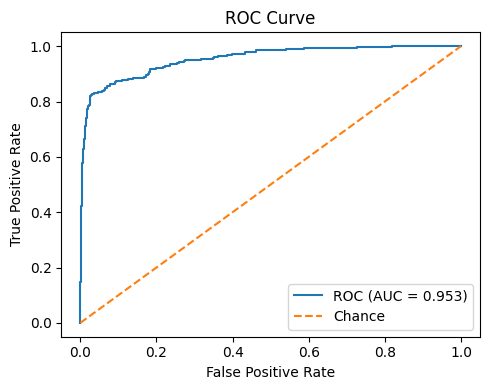

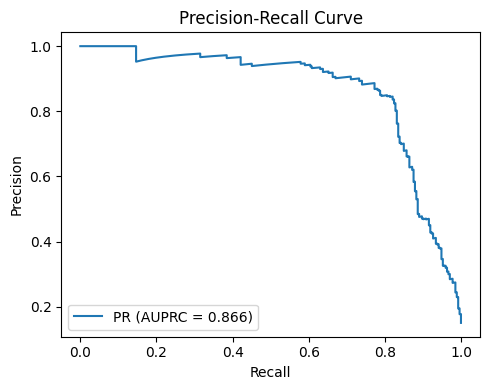

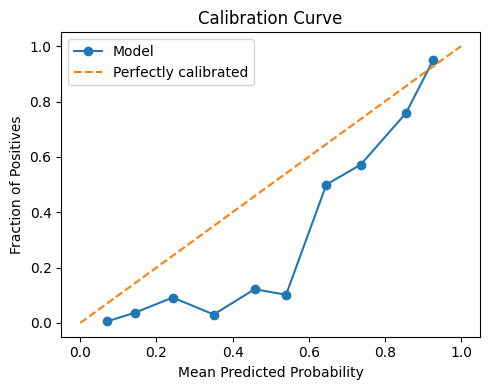

Calibrated test metrics:
 AUROC: 0.9479077701227961
 AUPRC: 0.8315305206439809
 Brier: 0.04412382954952874


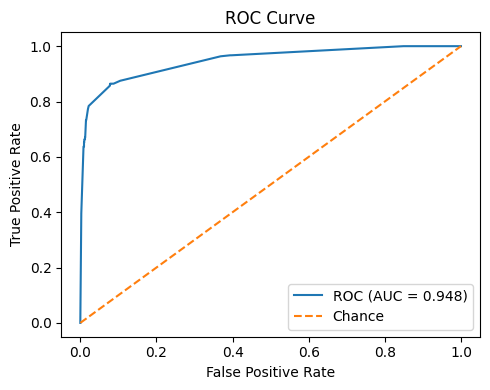

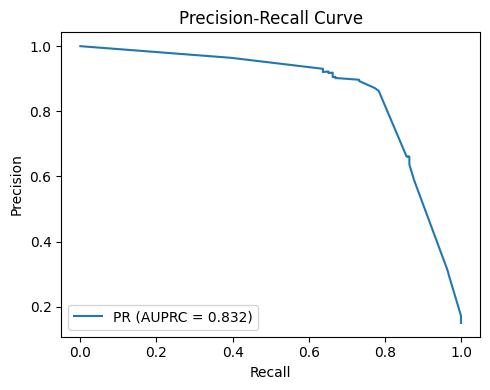

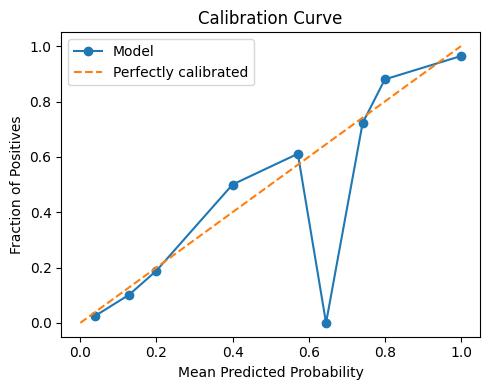

Saved isotonic and test probs.


In [24]:
# --- Calibration & uncalibrated evaluation ---
# 1) load val probs from ckpt if available, else recompute
val_probs = None
val_labels = None
if os.path.exists(best_ckpt):
    ck = torch.load(best_ckpt, map_location=DEVICE, weights_only=False)
    val_probs = ck.get('val_probs', None)
    val_labels = ck.get('val_labels', None)

if val_probs is None or val_labels is None:
    print("Validation probs not found in checkpoint. Computing from val_loader...")
    model.eval()
    val_probs_list, val_labels_list = [], []
    with torch.no_grad():
        for b in val_loader:
            s = b['static'].to(DEVICE); t = b['temp'].to(DEVICE); c = b['clin'].to(DEVICE); r = b['rad'].to(DEVICE)
            lbl = b['label'].cpu().numpy()
            logits, _ = model(s,t,c,r)
            p = torch.sigmoid(logits).cpu().numpy()
            val_probs_list.append(p); val_labels_list.append(lbl)
    val_probs = np.concatenate(val_probs_list)
    val_labels = np.concatenate(val_labels_list)
    joblib.dump({'val_probs': val_probs, 'val_labels': val_labels}, os.path.join(WORK_DIR, "val_probs_cache.pkl"))
    print("Saved val_probs_cache.pkl")

# 2) compute test probs (uncalibrated)
print("Computing uncalibrated test probabilities...")
model.eval()
test_probs_list, test_labels_list = [], []
with torch.no_grad():
    for b in test_loader:
        s = b['static'].to(DEVICE); t = b['temp'].to(DEVICE); c = b['clin'].to(DEVICE); r = b['rad'].to(DEVICE)
        lbl = b['label'].cpu().numpy()
        logits, _ = model(s,t,c,r)
        p = torch.sigmoid(logits).cpu().numpy()
        test_probs_list.append(p); test_labels_list.append(lbl)
test_probs = np.concatenate(test_probs_list)
test_labels = np.concatenate(test_labels_list)

print("Uncalibrated test metrics:")
print(" AUROC:", roc_auc_score(test_labels, test_probs))
print(" AUPRC:", average_precision_score(test_labels, test_probs))
print(" Brier:", brier_score_loss(test_labels, test_probs))
plot_roc_pr(test_labels, test_probs, out_prefix=f"test_uncal_{WINDOW}")
plot_calibration(test_labels, test_probs, out_prefix=f"test_uncal_{WINDOW}")

# 3) Fit isotonic on val and apply to test
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(val_probs, val_labels)
test_probs_cal = iso.transform(test_probs)

print("Calibrated test metrics:")
print(" AUROC:", roc_auc_score(test_labels, test_probs_cal))
print(" AUPRC:", average_precision_score(test_labels, test_probs_cal))
print(" Brier:", brier_score_loss(test_labels, test_probs_cal))
plot_roc_pr(test_labels, test_probs_cal, out_prefix=f"test_cal_{WINDOW}")
plot_calibration(test_labels, test_probs_cal, out_prefix=f"test_cal_{WINDOW}")

# Ensure checkpoint dir is defined
if "CHECKPOINT_DIR" not in globals():
    CHECKPOINT_DIR = WORK_DIR

# Save isotonic and probs
joblib.dump(iso, os.path.join(CHECKPOINT_DIR, f"isotonic_{WINDOW}.pkl"))
np.save(os.path.join(WORK_DIR, f"test_probs_{WINDOW}_uncal.npy"), test_probs)
np.save(os.path.join(WORK_DIR, f"test_probs_{WINDOW}_cal.npy"), test_probs_cal)
print("Saved isotonic and test probs.")


Concat shapes: (7558, 1696) (1817, 1696)
PCA shapes: (7558, 40) (1817, 40)
Background PCA shape: (200, 40) Explain shape: (50, 40)


  0%|          | 0/50 [00:00<?, ?it/s]

Saved PCA-SHAP results to: /kaggle/working/explain/shap_kernel_pca_fusion.pkl


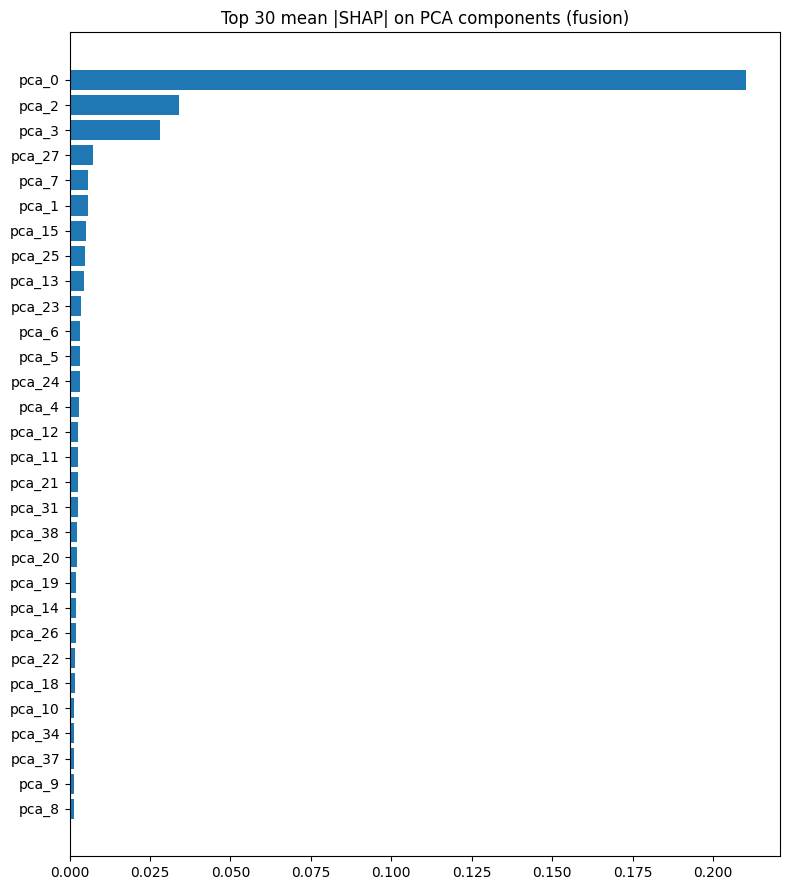

In [27]:
# --- SHAP explanation (KernelExplainer) on PCA-latent features ---

import gc
import numpy as np
import shap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import joblib

gc.collect()

# 1) Concatenate features from all modalities
X_train_concat = np.concatenate(
    [X_train_static, X_train_temp, X_train_clin, X_train_rad],
    axis=1
)
X_test_concat = np.concatenate(
    [X_test_static, X_test_temp, X_test_clin, X_test_rad],
    axis=1
)

print("Concat shapes:", X_train_concat.shape, X_test_concat.shape)

# 2) Fit PCA to reduce dimensionality
n_pca = 40  # 30–50 is reasonable; must be << background size
pca = PCA(n_components=n_pca, random_state=SEED)
X_train_pca = pca.fit_transform(X_train_concat)
X_test_pca = pca.transform(X_test_concat)

print("PCA shapes:", X_train_pca.shape, X_test_pca.shape)

# PCA-based feature names
feat_names = [f"pca_{i}" for i in range(n_pca)]

# 3) Wrapper: PCA-space -> original feature space -> model probabilities
def model_predict_pca(x_pca_np):
    """
    x_pca_np: (B, n_pca) in PCA space.
    1) invert PCA to original concatenated space,
    2) split into (static, temp, clin, rad),
    3) run through fusion model and return probabilities.
    """
    # back to original concatenated feature space
    x_np = pca.inverse_transform(x_pca_np)

    s_dim = X_train_static.shape[1]
    t_dim = X_train_temp.shape[1]
    c_dim = X_train_clin.shape[1]
    r_dim = X_train_rad.shape[1]

    s = x_np[:, :s_dim]
    t = x_np[:, s_dim:s_dim + t_dim]
    c = x_np[:, s_dim + t_dim:s_dim + t_dim + c_dim]
    r = x_np[:, s_dim + t_dim + c_dim:]

    s_t = torch.tensor(s, dtype=torch.float32).to(DEVICE)
    t_t = torch.tensor(t, dtype=torch.float32).to(DEVICE)
    c_t = torch.tensor(c, dtype=torch.float32).to(DEVICE)
    r_t = torch.tensor(r, dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        logits, _ = model(s_t, t_t, c_t, r_t)
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs

# 4) Background + explain sets in PCA space
bg_size = min(200, X_train_pca.shape[0])   # must be > n_pca + 1
sample_size = min(50, X_test_pca.shape[0])

rng = np.random.RandomState(SEED)
bg_idx = rng.choice(X_train_pca.shape[0], bg_size, replace=False)
sample_idx = rng.choice(X_test_pca.shape[0], sample_size, replace=False)

bg_pca = X_train_pca[bg_idx]
X_explain = X_test_pca[sample_idx]

print("Background PCA shape:", bg_pca.shape, "Explain shape:", X_explain.shape)

# 5) KernelSHAP on PCA features
explainer = shap.KernelExplainer(
    model_predict_pca,
    bg_pca
)

nsamples = 100  # keep reasonable for runtime

try:
    shap_vals = explainer.shap_values(X_explain, nsamples=nsamples)
    shap_vals = np.array(shap_vals)  # shape: (samples, n_pca)
    shap_failed = False
except Exception as e:
    print("\nKernelSHAP failed, skipping SHAP and relying on Captum + occlusion instead.")
    print("Error:", e)
    shap_vals = None
    shap_failed = True

# 6) Save SHAP results if successful
if not shap_failed:
    shap_outpath = os.path.join(EXPLAIN_DIR, f"shap_kernel_pca_{WINDOW}.pkl")
    joblib.dump(
        {
            'shap_vals': shap_vals,
            'X_explain_pca': X_explain,
            'feat_names': feat_names,
            'sample_idx': sample_idx,
            'pca_components': pca.components_,
            'pca_mean': pca.mean_,
        },
        shap_outpath
    )
    print("Saved PCA-SHAP results to:", shap_outpath)

    # 7) Global summary on PCA components
    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    topk = min(30, len(mean_abs))
    idx_sort = np.argsort(-mean_abs)[:topk]

    plt.figure(figsize=(8, max(4, topk * 0.3)))
    plt.barh(
        [feat_names[i] for i in idx_sort[::-1]],
        mean_abs[idx_sort][::-1]
    )
    plt.title(f"Top {topk} mean |SHAP| on PCA components ({WINDOW})")
    plt.tight_layout()
    plt.savefig(
        os.path.join(EXPLAIN_DIR, f"shap_pca_top{topk}_{WINDOW}.png"),
        bbox_inches='tight'
    )
    plt.show()
else:
    print("Skipping global PCA SHAP plot because SHAP failed.")


Mean |SHAP| per PCA component shape: (40,)
Original feature importance shape: (1696,)


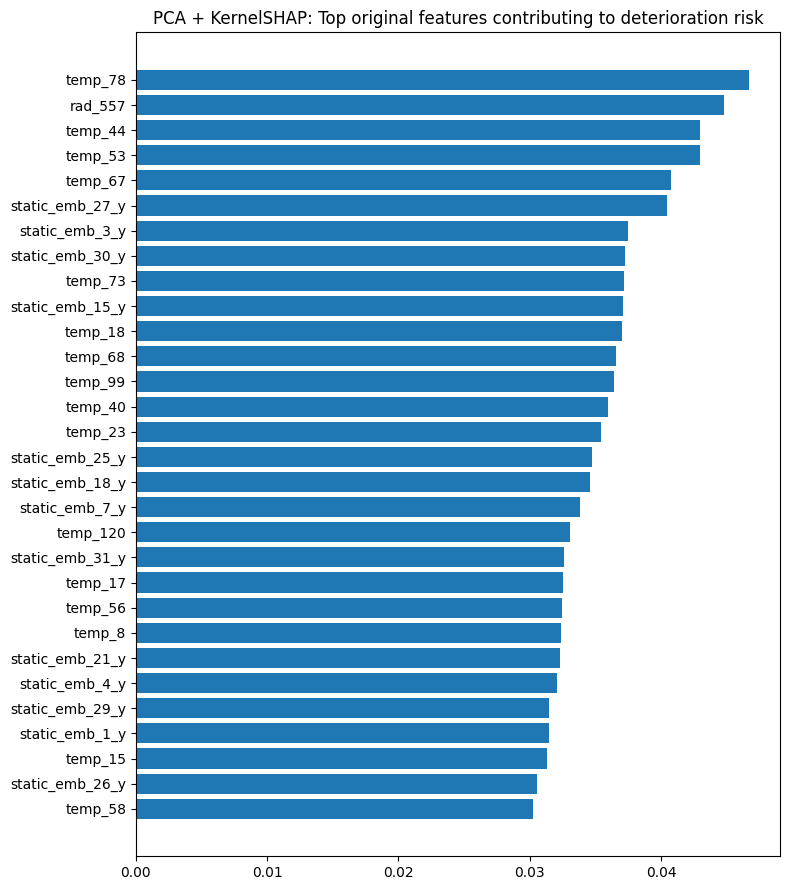

Saved PCA→original mapped SHAP results to: /kaggle/working/explain/pca_shap_orig_fusion.pkl


In [30]:
# --- Map PCA-SHAP global importance back to original features ---

import numpy as np
import matplotlib.pyplot as plt
import os

if shap_vals is None:
    print("No PCA-SHAP values available (shap_vals is None). Skipping mapping to original features.")
else:
    # 1) mean |SHAP| per PCA component
    mean_abs_pca = np.mean(np.abs(shap_vals), axis=0)  # (n_pca,)
    print("Mean |SHAP| per PCA component shape:", mean_abs_pca.shape)

    # 2) propagate importance to original feature space using PCA loadings
    components = pca.components_                      # (n_pca, D)
    D_concat = components.shape[1]

    orig_imp = np.sum(np.abs(mean_abs_pca[:, None] * components), axis=0)
    print("Original feature importance shape:", orig_imp.shape)

    # 3) reconstruct original feature names order
    feat_names_full = []
    if len(numeric_static) > 0:
        feat_names_full += numeric_static

    if 'X_train_cat' in globals() and X_train_cat.shape[1] > 0:
        feat_names_full += [f"cat_{i}" for i in range(X_train_cat.shape[1])]

    t_dim = X_train_temp.shape[1]
    c_dim = X_train_clin.shape[1]
    r_dim = X_train_rad.shape[1]

    feat_names_full += [f"temp_{i}" for i in range(t_dim)]
    feat_names_full += [f"clin_{i}" for i in range(c_dim)]
    feat_names_full += [f"rad_{i}" for i in range(r_dim)]

    if len(feat_names_full) != D_concat:
        print(f"WARNING: mismatch in feature naming length: {len(feat_names_full)} != {D_concat}")
        feat_names_full = [f"feat_{i}" for i in range(D_concat)]

    # 4) Top features contributing to deterioration risk
    topk = min(30, len(orig_imp))
    idx_top = np.argsort(-orig_imp)[:topk]

    plt.figure(figsize=(8, max(4, topk * 0.3)))
    plt.barh(
        [feat_names_full[i] for i in idx_top[::-1]],
        orig_imp[idx_top][::-1]
    )
    plt.title("PCA + KernelSHAP: Top original features contributing to deterioration risk")
    plt.tight_layout()
    plt.savefig(
        os.path.join(EXPLAIN_DIR, f"pca_shap_orig_top{topk}_{WINDOW}.png"),
        bbox_inches='tight'
    )
    plt.show()

    # 5) Save importance vectors
    pca_shap_path = os.path.join(EXPLAIN_DIR, f"pca_shap_orig_{WINDOW}.pkl")
    joblib.dump(
        {
            "mean_abs_pca": mean_abs_pca,
            "orig_imp": orig_imp,
            "feat_names_full": feat_names_full,
        },
        pca_shap_path
    )
    print("Saved PCA→original mapped SHAP results to:", pca_shap_path)


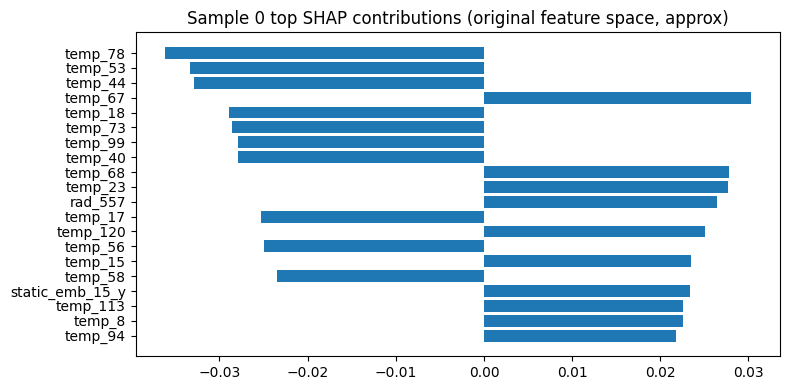

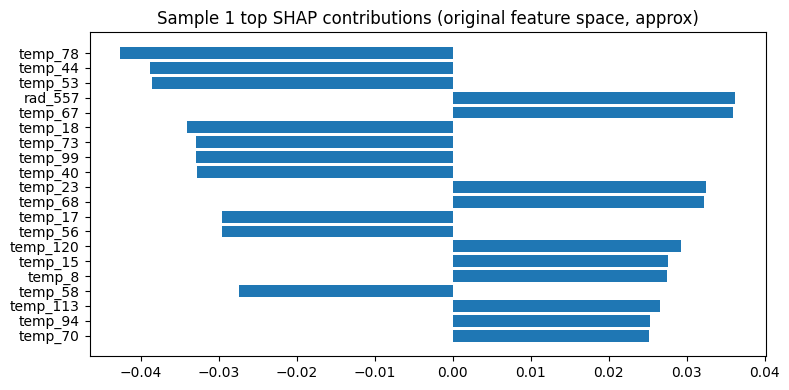

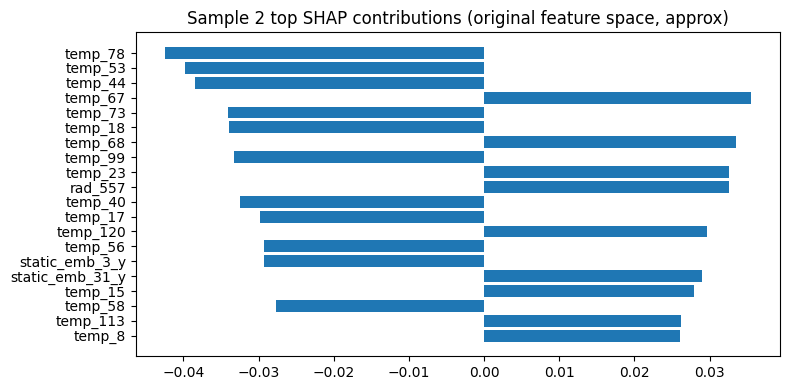

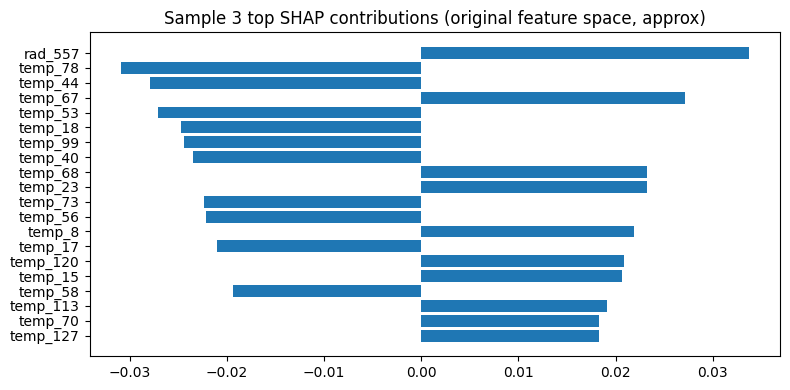

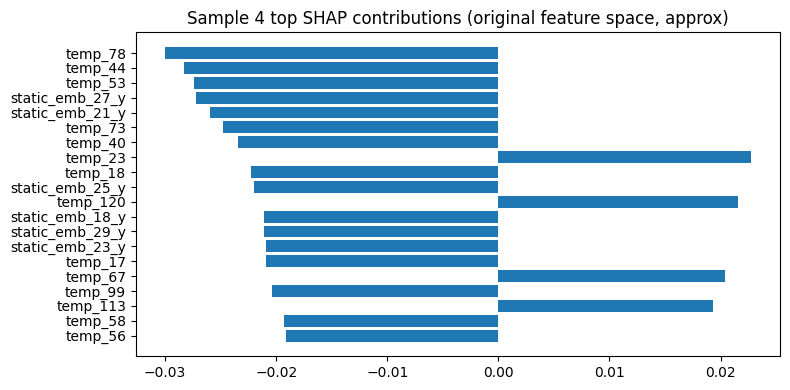

In [34]:
# --- Per-sample SHAP bar plots in ORIGINAL feature space (approx via PCA) ---

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

if shap_vals is None:
    print("No SHAP values computed (shap_vals is None). Skipping per-sample plots.")
else:
    components = pca.components_            # (n_pca, D_concat)
    D_concat = components.shape[1]

    # Rebuild full feature-name list if not already from previous cell
    if 'feat_names_full' not in globals() or len(feat_names_full) != D_concat:
        feat_names_full = []
        if len(numeric_static) > 0:
            feat_names_full += numeric_static

        if 'X_train_cat' in globals() and X_train_cat.shape[1] > 0:
            feat_names_full += [f"cat_{i}" for i in range(X_train_cat.shape[1])]

        t_dim = X_train_temp.shape[1]
        c_dim = X_train_clin.shape[1]
        r_dim = X_train_rad.shape[1]

        feat_names_full += [f"temp_{i}" for i in range(t_dim)]
        feat_names_full += [f"clin_{i}" for i in range(c_dim)]
        feat_names_full += [f"rad_{i}" for i in range(r_dim)]

        if len(feat_names_full) != D_concat:
            print(f"WARNING: mismatch in feature naming length: {len(feat_names_full)} != {D_concat}")
            feat_names_full = [f"feat_{i}" for i in range(D_concat)]

    sample_display = min(5, X_explain.shape[0])

    for i in range(sample_display):
        # SHAP values for this sample in PCA space
        phi_pca = shap_vals[i]                            # (n_pca,)

        # Map to original feature space: (n_pca,) @ (n_pca, D) -> (D,)
        phi_orig = np.dot(phi_pca, components)            # (D_concat,)

        # Top-k original features by |SHAP|
        topk = 20
        idxs = np.argsort(-np.abs(phi_orig))[:topk]
        names = [feat_names_full[j] for j in idxs]
        vals = phi_orig[idxs]

        plt.figure(figsize=(8, 4))
        plt.barh(names[::-1], vals[::-1])
        plt.title(f"Sample {i} top SHAP contributions (original feature space, approx)")
        plt.tight_layout()
        plt.savefig(
            os.path.join(EXPLAIN_DIR, f"shap_orig_sample_{i}_{WINDOW}.png"),
            bbox_inches='tight'
        )
        plt.show()


In [32]:
# --- save final artifacts and short CSV for clinicians ---

# If out_df already exists from Cell 6, reuse it.
if 'out_df' not in globals():
    out_df = test_df.reset_index(drop=True)[['subject_id', 'stay_id']].copy()
    out_df['raw_prob'] = test_probs
    # prefer calibrated probs if available
    if 'test_probs_cal' in globals():
        out_df['calibrated_prob'] = test_probs_cal
    elif 'test_probs_calibrated' in globals():
        out_df['calibrated_prob'] = test_probs_calibrated
    else:
        out_df['calibrated_prob'] = out_df['raw_prob']
    out_df['pred_label'] = (out_df['calibrated_prob'] >= 0.5).astype(int)

summary_csv = os.path.join(WORK_DIR, f"fusion_test_clinician_summary_{WINDOW}.csv")
out_df[['subject_id','stay_id','raw_prob','calibrated_prob','pred_label']].to_csv(
    summary_csv, index=False
)
print("Saved clinician summary CSV to:", summary_csv)
print("All explainability artifacts saved in:", EXPLAIN_DIR)


Saved clinician summary CSV to: /kaggle/working/fusion_test_clinician_summary_fusion.csv
All explainability artifacts saved in: /kaggle/working/explain


In [36]:
# =========================================================
# STEP 8: Baseline models (LogReg / RF / XGBoost)
# using concatenated static + temporal + clinical + radiology embeddings
# =========================================================

import numpy as np
import os
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    brier_score_loss
)

# optional XGBoost
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    print("xgboost not installed; XGBoost baseline will be skipped.")
    has_xgb = False

# ---------- 1. Build concatenated tabular features ----------
X_train_tab = np.concatenate(
    [X_train_static, X_train_temp, X_train_clin, X_train_rad],
    axis=1
)
X_val_tab = np.concatenate(
    [X_val_static, X_val_temp, X_val_clin, X_val_rad],
    axis=1
)
X_test_tab = np.concatenate(
    [X_test_static, X_test_temp, X_test_clin, X_test_rad],
    axis=1
)

print("Tabular baseline shapes:", X_train_tab.shape, X_val_tab.shape, X_test_tab.shape)
print("Label distributions:", np.mean(y_train), np.mean(y_val), np.mean(y_test))

# ---------- 2. Helper for evaluation ----------
def eval_baseline(name, model, X_tr, y_tr, X_val, y_val, X_te, y_te):
    print(f"\n===== {name} =====")
    model.fit(X_tr, y_tr)

    # probabilities for metrics
    if hasattr(model, "predict_proba"):
        val_probs = model.predict_proba(X_val)[:, 1]
        test_probs = model.predict_proba(X_te)[:, 1]
    else:
        scores_val = model.decision_function(X_val)
        scores_test = model.decision_function(X_te)
        from sklearn.preprocessing import MinMaxScaler
        mm = MinMaxScaler()
        val_probs = mm.fit_transform(scores_val.reshape(-1, 1)).ravel()
        test_probs = mm.transform(scores_test.reshape(-1, 1)).ravel()

    test_pred = (test_probs >= 0.5).astype(int)

    print("Val AUROC:", roc_auc_score(y_val, val_probs))
    print("Val AUPRC:", average_precision_score(y_val, val_probs))
    print("Test AUROC:", roc_auc_score(y_te, test_probs))
    print("Test AUPRC:", average_precision_score(y_te, test_probs))
    print("Test F1:", f1_score(y_te, test_pred))
    print("Test Brier:", brier_score_loss(y_te, test_probs))

    return {
        "name": name,
        "val_auroc": roc_auc_score(y_val, val_probs),
        "val_auprc": average_precision_score(y_val, val_probs),
        "test_auroc": roc_auc_score(y_te, test_probs),
        "test_auprc": average_precision_score(y_te, test_probs),
        "test_f1": f1_score(y_te, test_pred),
        "test_brier": brier_score_loss(y_te, test_probs),
    }

baseline_results = []

# ---------- 3. Logistic Regression (with scaling + more iterations) ----------
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=3000,          # increased to avoid convergence warning
        class_weight="balanced",
        solver="lbfgs"
    ))
])

baseline_results.append(
    eval_baseline(
        "LogisticRegression (concat embeddings)",
        logreg,
        X_train_tab, y_train,
        X_val_tab, y_val,
        X_test_tab, y_test
    )
)

# ---------- 4. Random Forest ----------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=SEED
)

baseline_results.append(
    eval_baseline(
        "RandomForest (concat embeddings)",
        rf,
        X_train_tab, y_train,
        X_val_tab, y_val,
        X_test_tab, y_test
    )
)

# ---------- 5. XGBoost ----------
if has_xgb:
    pos_ratio = (len(y_train) - y_train.sum()) / max(1, y_train.sum())
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=pos_ratio,
        n_jobs=-1,
        random_state=SEED,
        tree_method="hist"
    )

    baseline_results.append(
        eval_baseline(
            "XGBoost (concat embeddings)",
            xgb,
            X_train_tab, y_train,
            X_val_tab, y_val,
            X_test_tab, y_test
        )
    )

# ---------- 6. Summary table ----------
baseline_df = pd.DataFrame(baseline_results)
display(baseline_df)

baseline_csv = os.path.join(WORK_DIR, f"baselines_concat_embeddings_{WINDOW}.csv")
baseline_df.to_csv(baseline_csv, index=False)
print("Saved baseline comparison to:", baseline_csv)


Tabular baseline shapes: (7558, 1696) (776, 1696) (1817, 1696)
Label distributions: 0.17054776395871923 0.13659793814432988 0.15024766097963677

===== LogisticRegression (concat embeddings) =====
Val AUROC: 0.8501689664883132
Val AUPRC: 0.6021685182176431
Test AUROC: 0.8567941126231282
Test AUPRC: 0.7107300293393595
Test F1: 0.6473594548551959
Test Brier: 0.09050045321234268

===== RandomForest (concat embeddings) =====
Val AUROC: 0.9306251760067586
Val AUPRC: 0.8204260147194997
Test AUROC: 0.9468200193588794
Test AUPRC: 0.8676495850745471
Test F1: 0.8237623762376237
Test Brier: 0.04479322501002082

===== XGBoost (concat embeddings) =====
Val AUROC: 0.9164460715291467
Val AUPRC: 0.8134617648056408
Test AUROC: 0.9351145400368197
Test AUPRC: 0.8549912407855836
Test F1: 0.8188679245283018
Test Brier: 0.04706457028308176


,name,val_auroc,val_auprc,test_auroc,test_auprc,test_f1,test_brier
0,LogisticRegression (concat embeddings),0.850169,0.602169,0.856794,0.710730,0.647359,0.090500
1,RandomForest (concat embeddings),0.930625,0.820426,0.946820,0.867650,0.823762,0.044793
2,XGBoost (concat embeddings),0.916446,0.813462,0.935115,0.854991,0.818868,0.047065


Saved baseline comparison to: /kaggle/working/baselines_concat_embeddings_fusion.csv
